In [ ]:
!zip -r /kaggle/working/file.zip ../input/best-models

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
img_width, img_height = 120, 160

train_data_dir = '../input/main-dataset/main_dataset/train'
#validation_data_dir = '../input/main-dataset/main_dataset/validation'
test_data_dir = '../input/test-set/test'
nb_train_samples = 9957
nb_validation_samples = 2487
epochs = 30
batch_size = 32
#regularizer = tf.keras.regularizers.l2(0.01,)

if K.image_data_format() == 'channels_first':
  input_shape = (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

In [3]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.3,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    #classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],
    class_mode = 'categorical')

Found 9957 images belonging to 4 classes.


In [5]:
#valid_batches = test_datagen.flow_from_directory(
   # validation_data_dir,
   # target_size = (img_width, img_height),
    #batch_size = batch_size,
    #color_mode = 'grayscale',
    #class_mode = 'categorical')

In [6]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = 2487,
    #color_mode = 'grayscale',
    class_mode = 'categorical')

Found 2487 images belonging to 4 classes.


In [7]:
#train_batches = ImageDataGenerator().flow_from_directory(directory=train_data_dir, target_size=(120,160), classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], batch_size=batch_size)
#valid_batches = ImageDataGenerator().flow_from_directory(directory=validation_data_dir, target_size=(120,160), classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], batch_size=batch_size)
#test_batches = ImageDataGenerator().flow_from_directory(directory=test_data_dir, target_size=(120,160), classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], batch_size=600, shuffle=False)

In [8]:
def plots(ims, figsize=(12,6), rows=None, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [9]:
imgs, labels = next(train_batches)

In [10]:
#Eoisinophil=8[1.0.0.0],Lymphocyte=4[0.1.0.0],monocyte=2[0.0.1.0],neutrophil=1[0.0.0.1]-->Labels
#plots(imgs, rows=4, titles=labels)

In [28]:
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [29]:
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [30]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [31]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [32]:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [33]:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [34]:
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#model.add(Dense(32))
#model.add(Activation('relu'))

model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 120, 160, 3)       12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 120, 160, 32)      896       
_________________________________________________________________
activation_19 (Activation)   (None, 120, 160, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 60, 80, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 80, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 60, 80, 32)       

In [35]:
#model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
%%time
h = model.fit_generator(
    train_batches,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = test_batches,
    validation_steps = nb_validation_samples // batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
        tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ])

Epoch 1/30
311/311 [==============================] - 76s 245ms/step - loss: 1.3875 - accuracy: 0.2495 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 2/30
311/311 [==============================] - 76s 243ms/step - loss: 1.2638 - accuracy: 0.3749 - val_loss: 0.8480 - val_accuracy: 0.6377
Epoch 3/30
311/311 [==============================] - 76s 243ms/step - loss: 0.8659 - accuracy: 0.6136 - val_loss: 0.6360 - val_accuracy: 0.6844
Epoch 4/30
311/311 [==============================] - 75s 243ms/step - loss: 0.6845 - accuracy: 0.6623 - val_loss: 0.4869 - val_accuracy: 0.7358
Epoch 5/30
311/311 [==============================] - 75s 241ms/step - loss: 0.5700 - accuracy: 0.7260 - val_loss: 0.3927 - val_accuracy: 0.8363
Epoch 6/30
311/311 [==============================] - 75s 242ms/step - loss: 0.4781 - accuracy: 0.8090 - val_loss: 0.4000 - val_accuracy: 0.8741
Epoch 7/30
311/311 [==============================] - 75s 241ms/step - loss: 0.3968 - accuracy: 0.8515 - val_loss: 0.2683 - val_ac

In [39]:
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, rows=10, titles=test_labels)

In [40]:
rounded_labels = np.argmax(test_labels, axis=-1)

In [41]:
test_model = load_model('./model_0.920.h5')

In [42]:
predictions = test_model.predict_generator(test_batches, steps=1, verbose=0)

In [43]:
predictions

array([[1.3710523e-01, 3.6495611e-02, 8.9294486e-02, 7.3710471e-01],
       [8.9723651e-09, 2.3885365e-04, 9.9973601e-01, 2.5133200e-05],
       [1.0000000e+00, 2.1252510e-32, 7.0032492e-35, 2.3789243e-10],
       ...,
       [3.8787046e-11, 5.4613189e-05, 9.9994469e-01, 6.5946284e-07],
       [4.9442292e-14, 2.3032386e-07, 9.9999976e-01, 5.4367398e-08],
       [9.9445939e-01, 2.3407195e-11, 4.4775182e-12, 5.5406615e-03]],
      dtype=float32)

In [44]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [45]:
for i in rounded_prediction:
    print(i)

3
2
0
0
1
3
1
1
3
0
0
0
0
3
3
3
0
1
3
1
3
1
3
2
1
1
1
3
2
2
2
3
0
2
2
2
1
1
0
2
2
3
0
1
3
0
0
0
1
2
1
1
2
0
3
2
1
1
2
3
1
2
1
0
2
0
3
3
3
2
0
3
1
3
2
2
1
2
2
0
1
1
0
0
2
0
3
2
3
1
2
0
2
0
2
3
3
0
2
3
0
3
0
2
3
0
2
1
3
0
2
3
1
1
2
2
2
0
1
2
3
0
1
2
0
0
3
1
1
3
3
0
2
3
2
0
0
2
0
3
0
1
1
1
0
3
0
1
3
1
1
0
1
1
0
3
1
1
0
2
0
0
0
0
3
1
2
2
1
0
3
2
3
1
2
1
2
1
0
3
3
3
2
2
1
3
0
3
0
1
1
3
0
2
1
2
1
2
2
0
3
0
0
2
0
2
3
2
0
3
2
3
2
1
3
3
3
1
2
1
2
0
2
3
0
1
0
0
3
2
0
2
0
2
3
0
2
2
2
1
3
0
1
0
3
2
0
2
3
1
2
0
2
0
0
3
0
0
0
3
0
2
0
3
1
3
3
0
2
1
0
1
3
1
1
0
0
2
2
2
2
3
2
0
0
1
3
2
0
0
1
1
3
2
2
2
0
2
1
3
0
0
1
3
3
1
3
0
1
0
0
3
3
1
3
2
0
2
0
3
3
3
3
1
0
0
2
3
2
0
3
2
3
3
0
2
1
1
0
2
0
3
1
3
0
3
3
2
3
2
1
2
2
3
1
0
3
1
3
3
3
0
0
3
3
1
3
0
2
3
1
2
1
2
0
1
0
3
1
2
3
2
2
1
1
1
2
0
2
3
0
3
1
2
2
0
2
3
2
1
1
1
2
3
2
2
1
1
0
1
0
3
2
2
2
3
1
3
1
2
3
0
2
2
0
1
2
1
1
2
1
3
3
3
2
3
1
0
1
0
3
1
3
0
0
1
1
3
0
2
1
0
0
2
3
2
2
2
3
3
1
2
0
3
3
3
3
3
0
1
2
1
3
1
3
2
1
2
1
0
2
2
1
3
2
1
2
0
2
2
1
1
0
3
1
0
3
1
2
3


In [46]:
cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_prediction)

In [47]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[531   0   2  90]
 [  0 620   0   0]
 [  0  14 582  24]
 [ 61   0   9 554]]


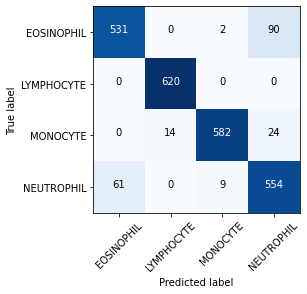

In [48]:
cm_plot_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [49]:
#test_accuracy--> 2287/2487 = 0.9195 or 91.95%

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


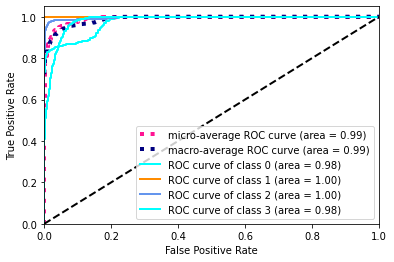

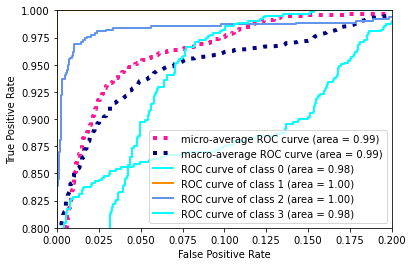

In [57]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(y_true=rounded_labels, y_pred=rounded_prediction))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       623
           1       0.98      1.00      0.99       620
           2       0.98      0.94      0.96       620
           3       0.83      0.89      0.86       624

    accuracy                           0.92      2487
   macro avg       0.92      0.92      0.92      2487
weighted avg       0.92      0.92      0.92      2487



In [53]:
score = metrics.log_loss(test_labels,predictions)
print("Log loss score: {}".format(score))

Log loss score: 0.2251245001956247


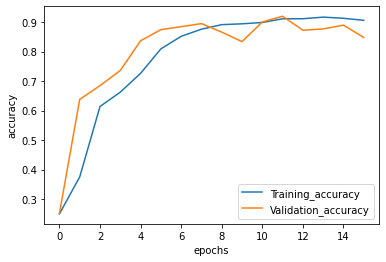

In [58]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

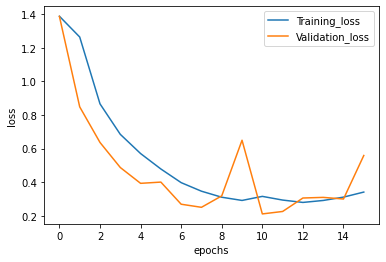

In [59]:
accs = h.history['loss']
val_accs = h.history['val_loss']

plt.plot(range(len(accs)),accs, label = 'Training_loss')
plt.plot(range(len(accs)),val_accs, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()